In [1]:
#!pip install lightgbm
#!pip install scikit-learn

In [1]:
import lightgbm as lgb
import bisect
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['font.family'] = 'Malgun Gothic'
# - 마이너스(-) 기호 처
plt.rcParams['axes.unicode_minus'] =False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 10)

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='whitegrid')

![컬럼 정보](./data/)

# train.csv EDA

In [2]:
train = pd.read_csv('C:/Users/Administrator/ship_project/data/origin/train.csv').drop(columns=['SAMPLE_ID'])
train['ATA'] = pd.to_datetime(train['ATA'])

In [3]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   ARI_CO              391939 non-null  object        
 1   ARI_PO              391939 non-null  object        
 2   SHIP_TYPE_CATEGORY  391939 non-null  object        
 3   DIST                391939 non-null  float64       
 4   ATA                 391939 non-null  datetime64[ns]
 5   ID                  391939 non-null  object        
 6   BREADTH             391938 non-null  float64       
 7   BUILT               391939 non-null  int64         
 8   DEADWEIGHT          391939 non-null  int64         
 9   DEPTH               391938 non-null  float64       
 10  DRAUGHT             391938 non-null  float64       
 11  GT                  391939 non-null  int64         
 12  LENGTH              391938 non-null  float64       
 13  SHIPMANAGER         391939 no

,DIST,ATA,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,391939.000000,391939,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,228251.000000,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
mean,19.328187,2019-07-30 18:57:19.733274368,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,-0.294910,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
min,0.000000,2014-09-01 00:05:00,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,0.000000,2017-07-06 23:00:30,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,6.929678,2019-10-28 06:26:00,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,25.692827,2021-10-05 09:09:30,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,1.540000,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111
max,199.980651,2023-02-28 14:55:00,60.00000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000,29.690000,47.600000,11.179660,23.000000,0.002615,2159.130556
std,30.930059,NaN,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,3.366585,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558


In [4]:
col_dic = {'ARI_CO':'도착국가',
            'ARI_PO':'도착 항구명',
            'SHIP_TYPE_CATEGORY':'5대 선종으로 분류',
            'DIST':'정박지와 접안지 거리(km)',
            'ATA':'실제 정박 시각(H)',
            'ID':'선박식별 일련번호',
            'BREADTH':'선박 폭(m)',
            'BUILT':'선박 연령',
            'DEADWEIGHT':'선박 재화중량톤수(t)',
            'DEPTH':'선박 깊이(m)',
            'DRAUGHT':'흘수 높이(m)',
            'GT':'용적톤수 값',
            'LENGTH':'선박 길이(m)',
            'SHIPMANAGER':'선박 소유주',
            'FLAG':'선박 국적',
            'U_WIND':'풍향 u벡터(m/s)',
            'V_WIND':'풍향 v벡터(m/s)',
            'AIR_TEMPERATURE':'기온(C)',
            'BN':'보퍼트 풍력 계급',
            'ATA_LT':'현지 정박 시각(H)',
            'DUBAI':'해당일의 두바이유 값($)',
            'BRENT':'해당일의 브렌트유 값($)',
            'WTI':'해당일의 WTI 값($)',
            'BDI_ADJ':'조정된 벌크운임지수',
            'PORT_SIZE':'접안지 폴리곤 영역의 크기',
            'CI_HOUR':'대기시간(h)'}

In [5]:
train = train.rename(columns=col_dic)
train.head(1)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),...,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),접안지 폴리곤 영역의 크기,대기시간(h)
0,SG,GIW5,Container,30.881018,2018-12-17 21:29:00,Z618338,30.0,24,24300,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.45


In [6]:
# 중복치 확인 
train.duplicated().sum()

0

In [7]:
# 결측치 확인
train.isnull().sum()

도착국가                    0
도착 항구명                  0
5대 선종으로 분류              0
정박지와 접안지 거리(km)         0
실제 정박 시각(H)             0
선박식별 일련번호               0
선박 폭(m)                 1
선박 연령                   0
선박 재화중량톤수(t)            0
선박 깊이(m)                1
흘수 높이(m)                1
용적톤수 값                  0
선박 길이(m)                1
선박 소유주                  0
선박 국적                   0
풍향 u벡터(m/s)        163688
풍향 v벡터(m/s)        163688
기온(C)              164630
보퍼트 풍력 계급          163688
현지 정박 시각(H)             0
접안지 폴리곤 영역의 크기          0
대기시간(h)                 0
dtype: int64

In [8]:
df = train.copy()
df

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),실제 정박 시각(H),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),...,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),접안지 폴리곤 영역의 크기,대기시간(h)
0,SG,GIW5,Container,30.881018,2018-12-17 21:29:00,Z618338,30.0,24,24300,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 06:59:00,X886125,30.0,13,35900,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00:00,T674582,50.0,12,146000,30.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 04:02:00,Y847238,20.0,18,6910,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 07:51:00,A872328,50.0,10,116000,20.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,JP,QYY1,Container,0.000000,2017-06-06 05:02:00,Y375615,20.0,27,6820,10.0,...,110.0,KEJZ24,"China, People's Republic Of",NaN,NaN,NaN,NaN,14,0.000552,0.000000
391935,SG,GIW5,Bulk,5.884603,2019-10-16 00:36:00,K635567,10.0,12,3160,10.0,...,80.0,JLTM64,Vietnam,-0.66,0.97,27.3,1.253491,8,0.002615,144.061389
391936,US,QGN3,Bulk,70.660241,2021-03-23 22:35:00,J284147,30.0,8,60300,20.0,...,200.0,YERJ68,Singapore,-3.44,7.99,21.1,4.766257,18,0.000155,41.482222
391937,TW,JWI3,Container,9.448179,2015-01-08 07:15:00,J644215,30.0,29,23800,10.0,...,170.0,HCZK58,Comoros,NaN,NaN,NaN,NaN,15,0.000990,7.485278


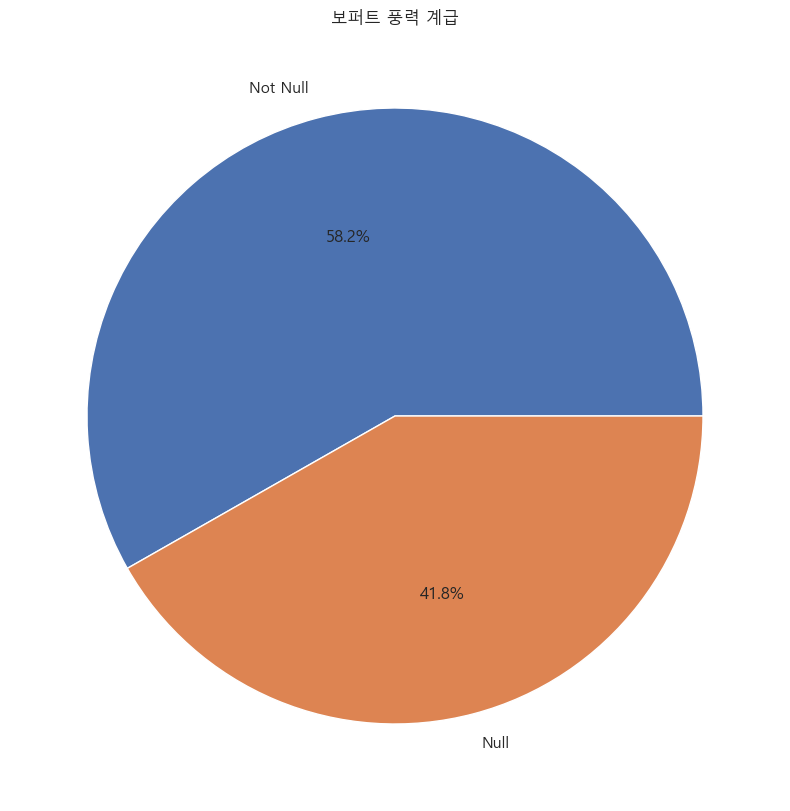

In [9]:
ntnull = len(df.loc[df['보퍼트 풍력 계급'].notnull()])/len(df) * 100
null = len(df.loc[df['보퍼트 풍력 계급'].isnull()])/len(df) * 100

values = [ntnull, null]
labels = ['Not Null', 'Null']  # 레이블 설정

# 파이 차트 그리기
plt.pie(values, labels=labels, autopct='%.1f%%')
plt.title('보퍼트 풍력 계급')
plt.show()

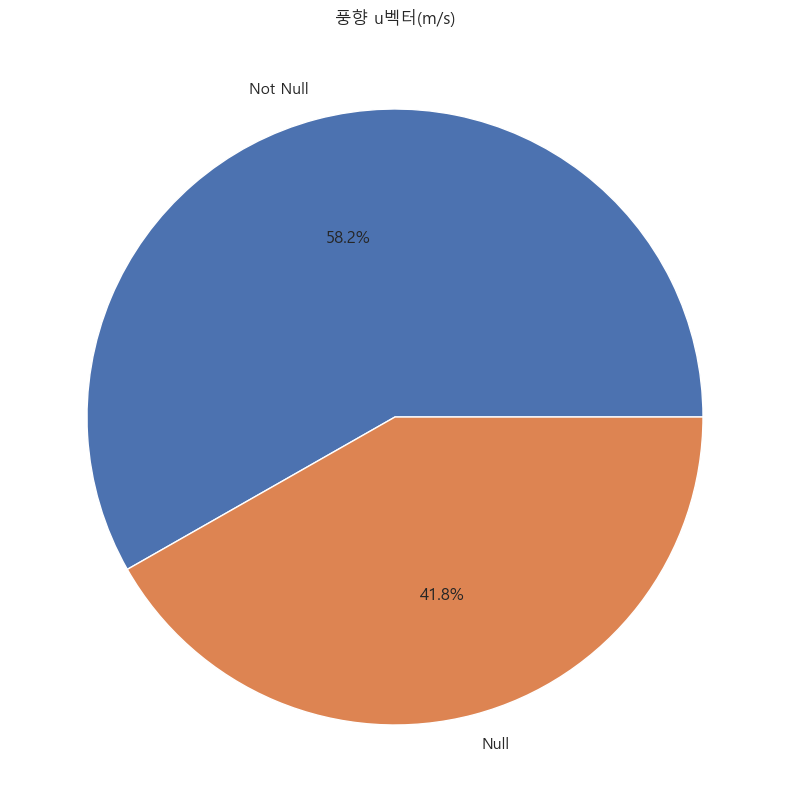

In [10]:
ntnull = len(df.loc[df['풍향 u벡터(m/s)'].notnull()])/len(df) * 100
null = len(df.loc[df['풍향 u벡터(m/s)'].isnull()])/len(df) * 100

values = [ntnull, null]
labels = ['Not Null', 'Null']  # 레이블 설정

# 파이 차트 그리기
plt.pie(values, labels=labels, autopct='%.1f%%')
plt.title('풍향 u벡터(m/s)')
plt.show()

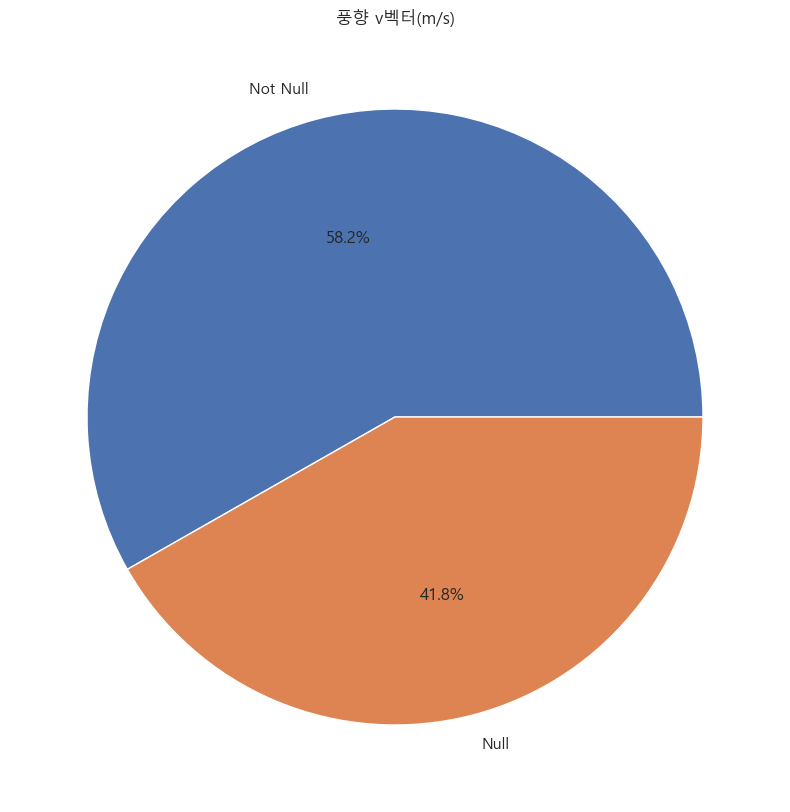

In [11]:
ntnull = len(df.loc[df['풍향 v벡터(m/s)'].notnull()])/len(df) * 100
null = len(df.loc[df['풍향 v벡터(m/s)'].isnull()])/len(df) * 100

values = [ntnull, null]
labels = ['Not Null', 'Null']  # 레이블 설정

# 파이 차트 그리기
plt.pie(values, labels=labels, autopct='%.1f%%')
plt.title('풍향 v벡터(m/s)')
plt.show()

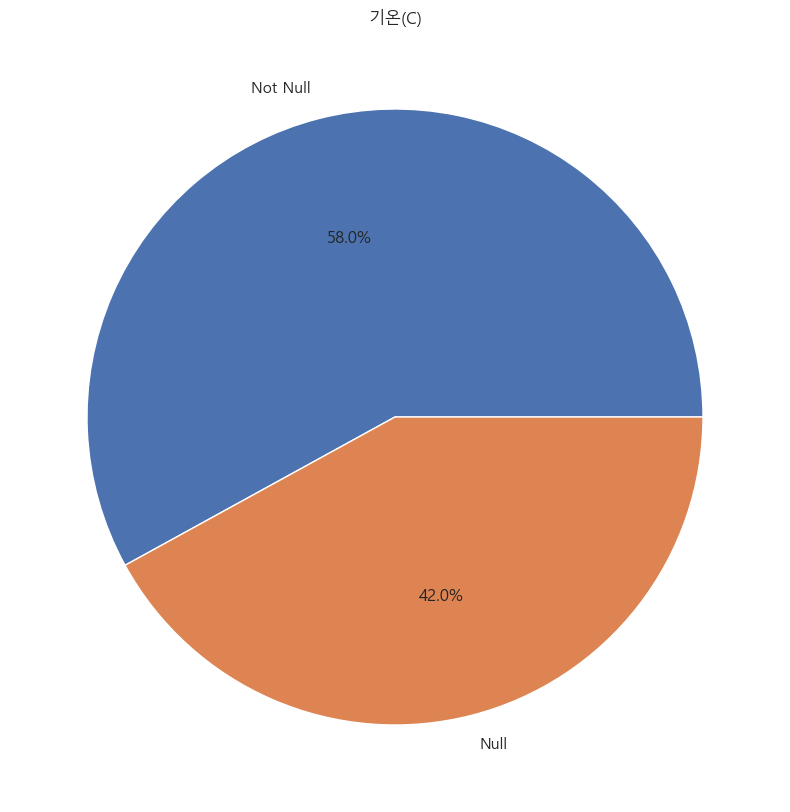

In [13]:
ntnull = len(df.loc[df['기온(C)'].notnull()])/len(df) * 100
null = len(df.loc[df['기온(C)'].isnull()])/len(df) * 100

values = [ntnull, null]
labels = ['Not Null', 'Null']  # 레이블 설정

# 파이 차트 그리기
plt.pie(values, labels=labels, autopct='%.1f%%')
plt.title('기온(C)')
plt.show()

In [14]:
df.columns

Index(['도착국가', '도착 항구명', '5대 선종으로 분류', '정박지와 접안지 거리(km)', '실제 정박 시각(H)',
       '선박식별 일련번호', '선박 폭(m)', '선박 연령', '선박 재화중량톤수(t)', '선박 깊이(m)', '흘수 높이(m)',
       '용적톤수 값', '선박 길이(m)', '선박 소유주', '선박 국적', '풍향 u벡터(m/s)', '풍향 v벡터(m/s)',
       '기온(C)', '보퍼트 풍력 계급', '현지 정박 시각(H)', '접안지 폴리곤 영역의 크기', '대기시간(h)'],
      dtype='object')

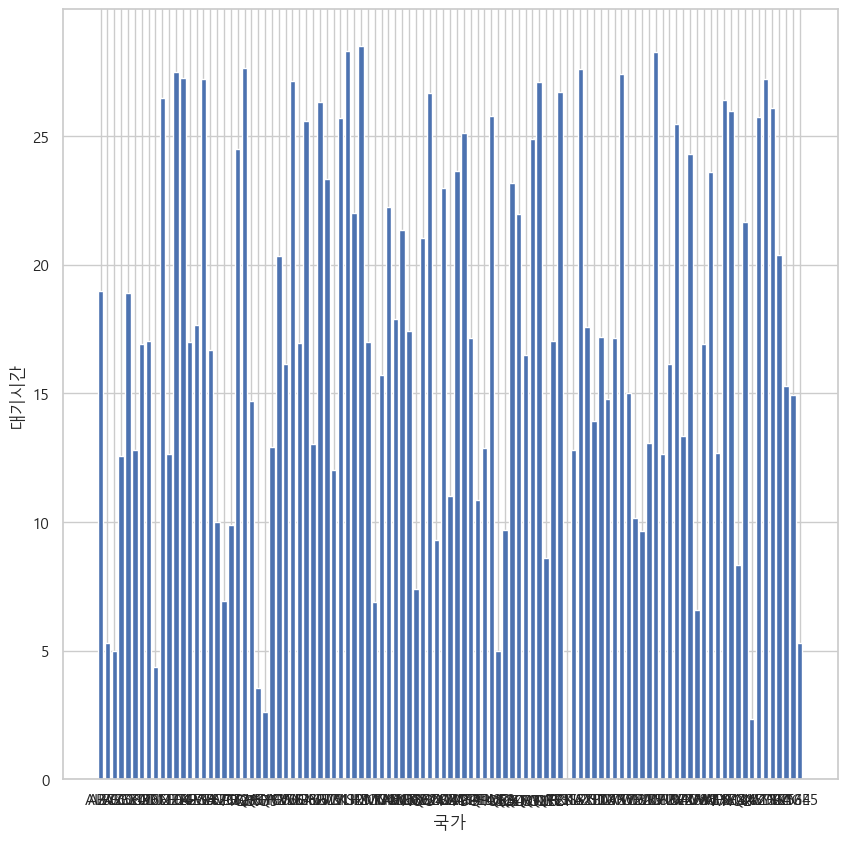

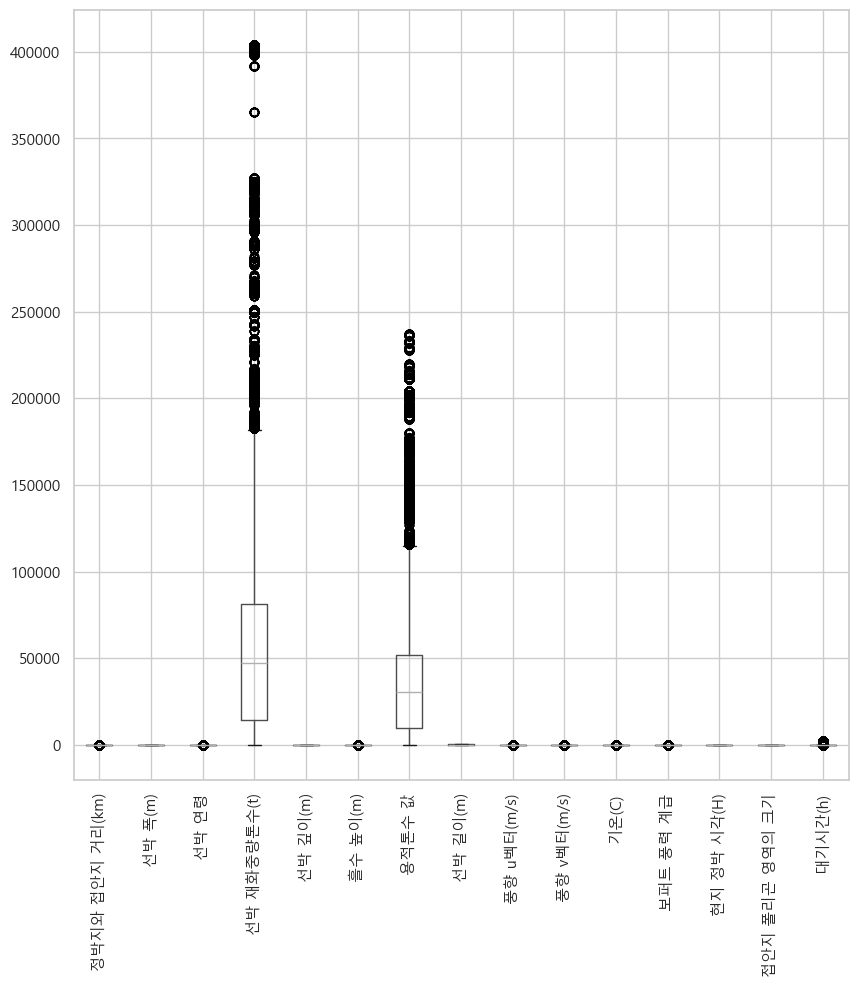

In [14]:
# 이상치 확인
df.boxplot()
plt.xticks(rotation=90);

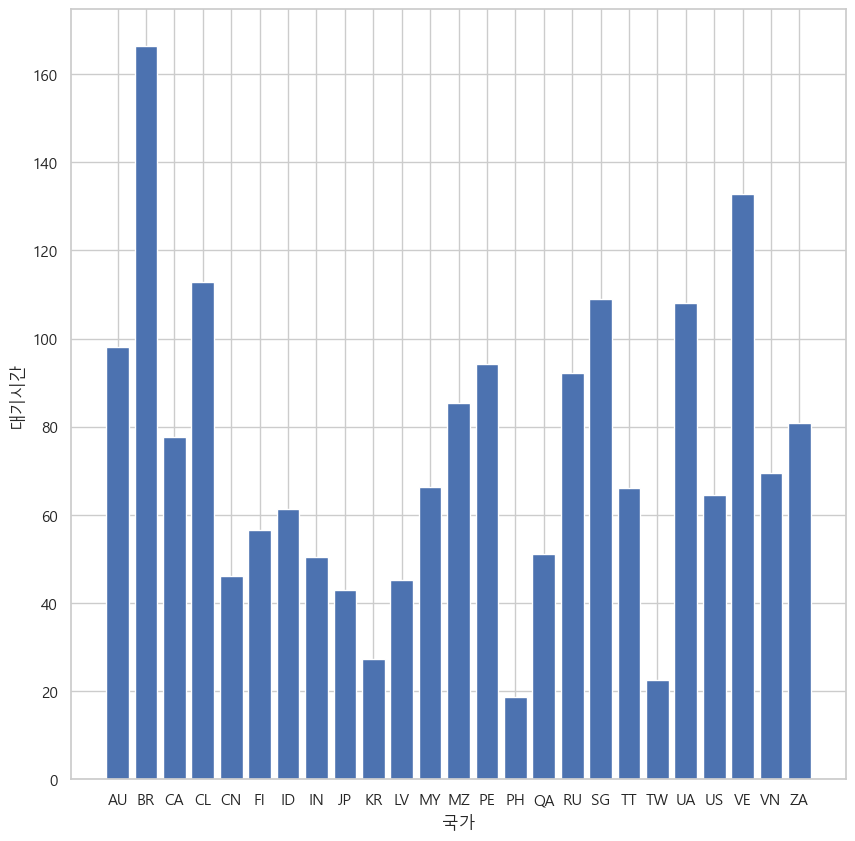

In [15]:
df_nation = df.groupby('도착국가')['대기시간(h)'].mean()
# 인덱스 리스트로
label = df_nation.index

# 인덱스를 X, 평균 가격을 Y로 하는 막대 그래프 
plt.bar(label, df_nation)
plt.xlabel('국가')
plt.ylabel('대기시간')
plt.show();

In [16]:
df.columns

Index(['도착국가', '도착 항구명', '5대 선종으로 분류', '정박지와 접안지 거리(km)', '실제 정박 시각(H)',
       '선박식별 일련번호', '선박 폭(m)', '선박 연령', '선박 재화중량톤수(t)', '선박 깊이(m)', '흘수 높이(m)',
       '용적톤수 값', '선박 길이(m)', '선박 소유주', '선박 국적', '풍향 u벡터(m/s)', '풍향 v벡터(m/s)',
       '기온(C)', '보퍼트 풍력 계급', '현지 정박 시각(H)', '접안지 폴리곤 영역의 크기', '대기시간(h)'],
      dtype='object')

In [ ]:
df_port =